<div style="text-align: right"> Выполнил Цветков Алексей, MLE-22</div>

This research is based on paper https://arxiv.org/pdf/1912.03223.pdf

Тут два класса, чтобы читать данные.

In [111]:
import torch
import os
import numpy as np

from PIL import Image


class OCRTaskDataset(torch.utils.data.Dataset):
    FOLDER_NAME = "samples"

    def __init__(self, encoder, items_names=None, path_to_images=None):
        super(OCRTaskDataset, self).__init__()
        if not path_to_images:
            self.path = os.path.abspath(os.getcwd()) + "\\" + self.FOLDER_NAME
        else:
            self.path = path_to_images

        if not items_names:
            self.items = [f for f in os.listdir(self.path) if
                          os.path.isfile(os.path.join(self.path, f))]
        else:
            self.items = items_names
        
        self.encoder = encoder

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        assert index <= len(self)
        image = Image.open(self.path + "\\" + self.items[index]).convert("RGB")
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        label = self.items[index].split('.')[0]

        return {'image': torch.FloatTensor(image),
                'label': self.encoder.encode(label)}

In [112]:
class OCRLabelConverter(object):
    
    def __init__(self, alphabet):
        alphabet.sort()
        self.enc_dict = {x: i for i, x in enumerate(alphabet, start=1)}
        self.enc_dict[''] = 0
        self.dec_dict = {y: x for x, y in self.enc_dict.items()}
        
        self.size = len(alphabet) + 1
    
    def encode(self, text):
        return torch.IntTensor([self.enc_dict[t] for t in text])
    
    def _remove_duplicates(self, predictions):
        return [predictions[i] for i in range(len(predictions)) 
                if (i == 0) or predictions[i] != predictions[i - 1]]
    
    def decode(self, predictions):
        new_pred = self._remove_duplicates(predictions)
        text = ""
        for p in predictions:
            if p != 0:
                text += self.dec_dict[p]
        return text

Читаем данные.

In [113]:
CURR_PATH = os.path.abspath(os.getcwd()) + "\\samples"

In [114]:
import functools
import operator

files = os.listdir(CURR_PATH)
alphabet = list(set(functools.reduce(operator.iconcat, 
                            [list(elem.split(".")[0]) 
                             for elem in files],
                            [])))

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
train, test = train_test_split(files, test_size=0.2)

In [117]:
converter = OCRLabelConverter(alphabet)

In [118]:
train_data = OCRTaskDataset(encoder=converter, items_names=train)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)

In [119]:
test_data = OCRTaskDataset(encoder=converter, items_names=test)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True)

Теперь берем модель, которая представлена в статье (но при этом все же оставляем RGB)

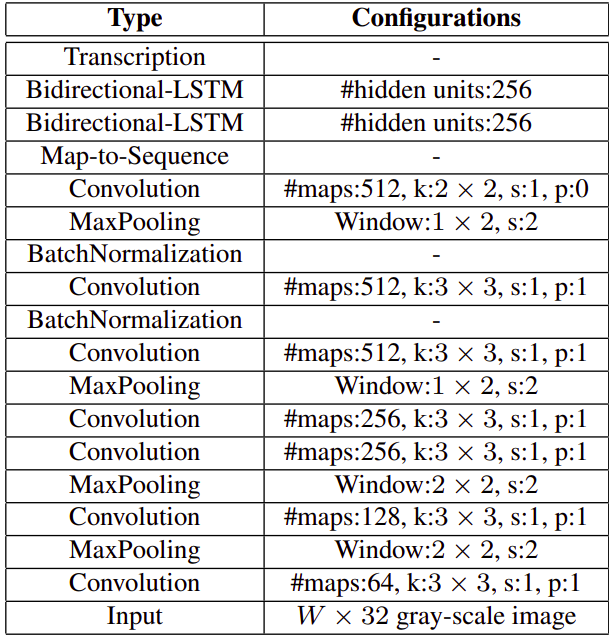

In [124]:
import torch.nn as nn

class OCRTaskModel(nn.Module):
    def __init__(self, size):
        super(OCRTaskModel, self).__init__()
        
        # first part
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,
                              kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128,
                              kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(),
    
            nn.Conv2d(in_channels=128, out_channels=256,
                              kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=512,
                              kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                              kernel_size=2, stride=1, padding=0)
        )
        
        # second part
        self.lin_1 = nn.Linear(512, 512)
        self.lstm_1 = nn.LSTM(512, 256, num_layers=1, bidirectional=True)
        self.lin_2 = nn.Linear(512, 256)
        self.lstm_2 = nn.LSTM(256, 256, num_layers=1, bidirectional=True)
        self.lin_3 = nn.Linear(512, size)
        
    def forward(self, x):
        x = self.cnn(x)
        
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)
        
        x = self.lin_1(x)
        x, _ = self.lstm_1(x)
        x = self.lin_2(x)
        x, _ = self.lstm_2(x)
        x = self.lin_3(x)
        
        return torch.nn.functional.log_softmax(x, 2)

In [125]:
model = OCRTaskModel(size=len(alphabet))

In [126]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [129]:
criterion = torch.nn.CTCLoss()

In [ ]:
epochs = 100

for e in range(epochs):
    model.train()
    
    
    
    for batch in

TypeError: 'DataLoader' object is not subscriptable